In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/phd/project_af')

# pip install sklearn==0.23.1 
# pip install torch

In [2]:
from helper_functions import *
from model_classes import *

In [3]:
# load data
data = pd.read_csv("./data/data_9s.csv")
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2694,2695,2696,2697,2698,2699,2700,2701,2702,2703
0,-127,-162,-197,-229,-245,-254,-261,-265,-268,-268,...,-48,-49,-50,-49,-48,-45,N,train,A00001,0
1,-41,-35,-28,-19,12,69,151,257,382,522,...,10,10,10,9,9,8,N,train,A00001,1
2,7,7,6,4,3,2,2,3,4,6,...,53,50,46,42,36,29,N,train,A00001,2
3,128,157,189,226,250,257,262,265,268,269,...,-2,0,1,4,7,10,N,test,A00002,0
4,13,15,18,21,24,27,31,35,41,48,...,-154,-134,-112,-88,-66,-31,N,test,A00002,1


In [4]:
class Dataset_Spectrogram(Dataset):
    def __init__(self, df_x, df_y):
        self.df_x = df_x
        self.df_y = df_y
        
    def __len__(self):
        return(self.df_x.shape[0])
    
    def __getitem__(self, idx):
        x = self.df_x.iloc[idx,:] # 1d signal of x
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        fig, ax = plt.subplots(figsize=(5,3))
        ax.specgram(x, Fs=300)
        plt.axis("off")
        plt.tight_layout()
        plt.close() # no need to show the plot
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        width, height = fig.get_size_inches() * fig.get_dpi()
        x_3d_spec_r = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
        x_3d_spec_r = torch.Tensor(x_3d_spec_r).permute(2, 0, 1) # Reshape it to (channel, height, width)
        X = x_3d_spec_r/255.0 # normalize

        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(np.array(self.df_y).reshape(-1,1))
        y = ohe.transform(np.array(self.df_y.iloc[idx,:]).reshape(-1,1))
        y = torch.tensor(y, dtype=torch.float32).squeeze(dim=0) 
        
        return X, y


# use Dataset and DataLoader
train_data = Dataset_Spectrogram(df_x=data[data.iloc[:,2701]=="train"].iloc[:,range(9*300)], df_y=data[data.iloc[:,2701]=="train"].iloc[:,[2700]])
valid_data = Dataset_Spectrogram(df_x=data[data.iloc[:,2701]=="valid"].iloc[:,range(9*300)], df_y=data[data.iloc[:,2701]=="valid"].iloc[:,[2700]])
test_data = Dataset_Spectrogram(df_x=data[data.iloc[:,2701]=="test"].iloc[:,range(9*300)], df_y=data[data.iloc[:,2701]=="test"].iloc[:,[2700]])
batch_size = 80
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, pin_memory=True)    


for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

<ipython-input-4-f76a56635b27>:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x_3d_spec_r = torch.Tensor(x_3d_spec_r).permute(2, 0, 1) # Reshape it to (channel, height, width)


torch.Size([80, 3, 216, 360])
torch.Size([80, 4])


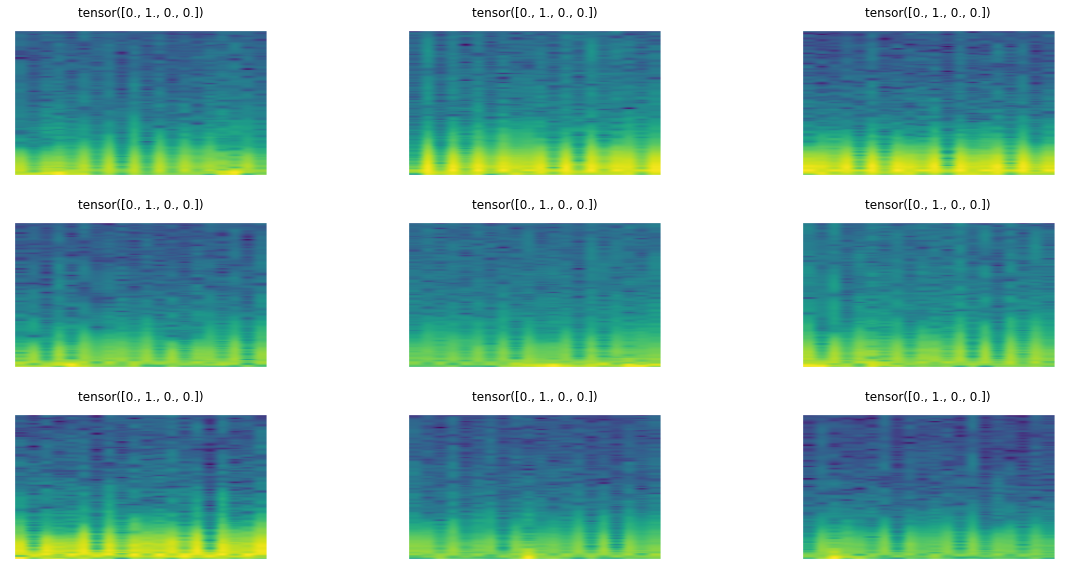

In [5]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{images[i][1]}')
        ax.imshow(images[i][0].squeeze(dim=0).permute(1,2,0))
        ax.axis('off')
        

images = [(image, label) for image, label in [train_data[i] for i in range(9)]]
plot_images(images)

In [6]:
# batch_size, epoch and iteration
n_iters = 10000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


# set up device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device", device)

# learning rate list
lr_list = [0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]

# initiate model object by name
model_name = "cnn_conv2d_vgg16_custom"
if model_name.__eq__("cnn_conv2d_vgg16"):
    model = cnn_conv2d_vgg16(dim_out=4).to(device)
if model_name.__eq__("cnn_conv2d_ggl"):
    model = cnn_conv2d_ggl(dim_out=4).to(device)
if model_name.__eq__("cnn_conv2d_diy"):
    model = cnn_conv2d_diy(dim_out=4).to(device)
if model_name.__eq__("cnn_conv2d_vgg16_custom"):
    model = cnn_conv2d_vgg16_custom(dim_out=4).to(device) 
    
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total number of parameters in {model_name}: {num_param}")

# initiate optimizer
lr_past = lr_list[0]
optimizer = torch.optim.SGD(model.parameters(), lr=lr_past) 

# initiate loss module
loss_module = nn.CrossEntropyLoss()

# specify continuing checkpoints
file_path = './model/'+str(model_name)+'.pth' # Define the file path where the model is saved
if os.path.exists(file_path):
    print("continue from last checkpoint")
    checkpoint = torch.load(file_path)# Load the model and other training-related information
    model.load_state_dict(checkpoint['model_state_dict']) # Load model weights
    loss_module = checkpoint['loss_module']
    lr_past = 0.005#checkpoint['lr'] # check model folder to see what is the last learning rate
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])# Load optimizer state if needed
    eval_df = checkpoint['eval_df'] # load eval_df from previous checkpoints
    plt.plot(eval_df['tf'])
    plt.plot(eval_df['vf'])
    plt.show;


41
Device cuda


/home/jq2uw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jq2uw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


total number of parameters in cnn_conv2d_vgg16_custom: 1768900


In [ ]:
for lr in [l for l in lr_list if l < lr_past]:
    print("learning rate = "+str(lr))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    tl, vl, ta, va, tf, vf = train_model(model, optimizer, train_loader, valid_loader, loss_module, num_epochs, device)
    # keep track of training and validation evaluation matrics
    eval_df_new = pd.DataFrame({"tl":tl,
                           "vl":vl,
                           "ta":ta,
                           "va":va,
                           "tf":tf,
                           "vf":vf})
    if 'eval_df' in locals() or 'eval_df' in globals():
        eval_df = pd.concat([eval_df, eval_df_new]) # add to checkpoint eval_df
        eval_df = eval_df.reset_index(drop=True)
    else:
        eval_df = eval_df_new
    # Save the model's state dictionary and any other necessary information
    torch.save({
        "eval_df": eval_df,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),  
        'loss_module': loss_module,
        'lr': lr,
    }, file_path)
    print(f'Model saved to {file_path}')

learning rate = 0.001


--- train ---
 accuracy: 58.40% loss: 1.0386 f1: 0.1843
--- valid ---
 accuracy: 58.34% loss: 1.0366 f1: 0.1842


--- train ---
 accuracy: 58.40% loss: 0.9611 f1: 0.1843
--- valid ---
 accuracy: 58.34% loss: 0.9596 f1: 0.1842


--- train ---
 accuracy: 58.40% loss: 0.9541 f1: 0.1843
--- valid ---
 accuracy: 58.34% loss: 0.9528 f1: 0.1842


--- train ---
 accuracy: 58.40% loss: 0.9461 f1: 0.1843
--- valid ---
 accuracy: 58.34% loss: 0.9452 f1: 0.1842


